In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
labels_dict = {'wanita_mojaris': 'wanita mojaris',
 'pria_kurta': 'pria kurta',
 'blus': 'blus',
 'rok_dalam': 'rok',
 'lehenga': 'lehenga',
  'jaket_nehru': 'jaket nehru',
 'celana_dhoti': 'celana dhoti',
 'palazzo': 'palazzo',
 'sari': 'sari',
 'dupatta': 'dupatta',
 'pria_mojaris': 'pria mojaris',
 'sherwani': 'sherwani',
 'gaun': 'gaun',
 'legging_dan_salwar': 'legging dan salwar',
 'wanita_kurta': 'wanita kurta'}

labels = list(labels_dict.values())

In [5]:
import os


# DRIVE_DIR = "/content/gdrive/MyDrive/Nella/CLIP/"
DRIVE_DIR = "/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Project/CLIP/"
MODEL_DIR = os.path.join(DRIVE_DIR, "model/")
RESULT_DIR = os.path.join(DRIVE_DIR, "result/")
DATA_DIR = os.path.join(DRIVE_DIR, "data/")
FASHION_DIR = os.path.join(DATA_DIR, "indo_fashion/")
FASHION_MINI_DIR = os.path.join(DATA_DIR, "indo_fashion_mini/")
BEST_PATH = os.path.join(MODEL_DIR, "CLIP_fashion_best3")

In [6]:
from PIL import Image
import requests

from transformers import CLIPProcessor, VisionTextDualEncoderModel, AutoTokenizer, BertTokenizer

model_base = VisionTextDualEncoderModel.from_pretrained("Galuh/clip-indonesian", from_flax=True)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
processor.tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-large-p2")

model_best = VisionTextDualEncoderModel.from_pretrained(BEST_PATH, from_flax=True)

All Flax model weights were used when initializing VisionTextDualEncoderModel.

All the weights of VisionTextDualEncoderModel were initialized from the Flax model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use VisionTextDualEncoderModel for predictions without further training.


In [7]:
import pandas as pd

test_df = pd.read_csv(os.path.join(FASHION_MINI_DIR,"test.csv"))

In [8]:
test_df = test_df[["image_path", "ID_product_title", "ID_class_label"]]
test_df = test_df.dropna()

In [9]:
image_path_list = test_df["image_path"].apply(lambda x: os.path.join(FASHION_MINI_DIR, x)).tolist()
caption_list = test_df["ID_product_title"].tolist()
label_list = test_df["ID_class_label"].apply(lambda x: labels_dict[x]).tolist()

In [10]:
len(image_path_list)

4500

In [11]:
test_df.iloc[0]

image_path                                      images/test/3821.jpeg
ID_product_title    Hijau Limau & amp; Lehenga &amp; Blus Tanpa Ja...
ID_class_label                                                lehenga
Name: 0, dtype: object

## Zero-Shot Classification

In [ ]:
from PIL import Image

In [ ]:
image_path =os.path.join(FASHION_MINI_DIR, test_df.iloc[0]["image_path"])
assert image_path == image_path_list[0]
image = Image.open(image_path)
display(image)

In [ ]:
inputs = processor(text=labels, images=image, return_tensors="pt", padding=True)

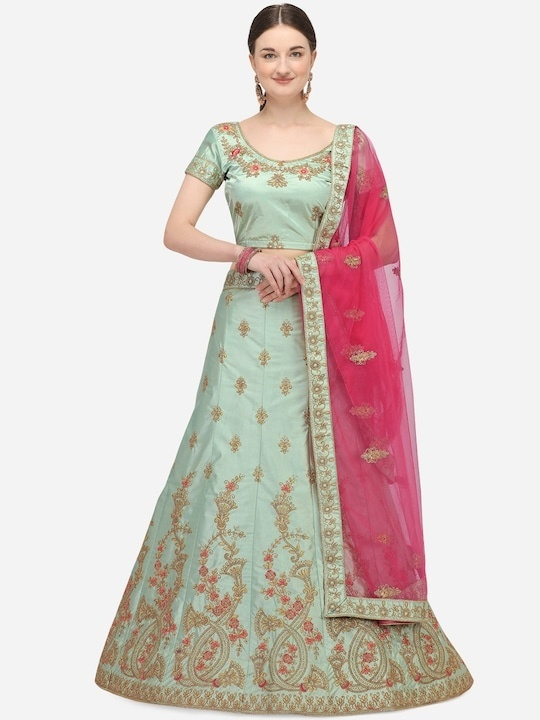


gaun: 11.70%
blus: 11.31%
sari: 8.18%
rok: 7.55%
celana dhoti: 7.27%
sherwani: 6.70%
dupatta: 6.55%
wanita kurta: 6.37%
jaket nehru: 5.99%
wanita mojaris: 5.86%
legging dan salwar: 5.43%
pria mojaris: 5.42%
pria kurta: 4.93%
lehenga: 4.76%
palazzo: 1.98%


In [ ]:
# Base CLIP INDONESIA
outputs = model_base(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

display(image)

print()
for idx, prob in sorted(enumerate(*probs), key=lambda x: x[1], reverse=True):
  print(f"{labels[idx]}: {prob.item():.2%}")

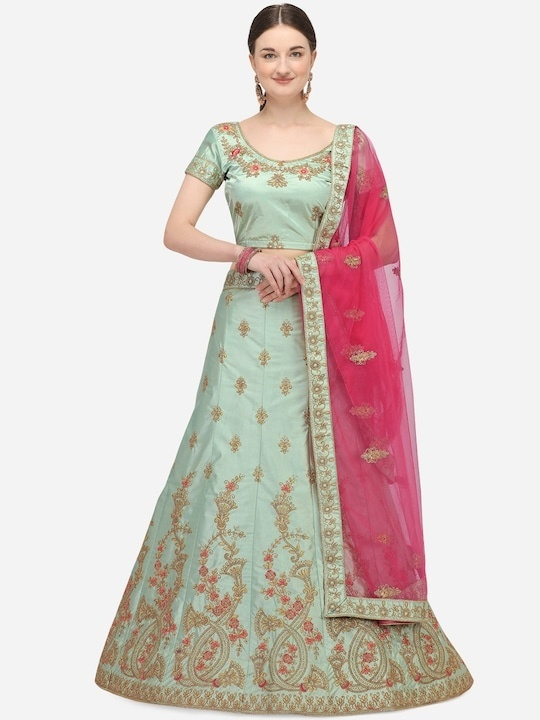


lehenga: 61.01%
wanita kurta: 4.32%
jaket nehru: 3.64%
pria kurta: 3.49%
sherwani: 3.43%
palazzo: 3.19%
wanita mojaris: 3.05%
pria mojaris: 3.02%
legging dan salwar: 2.96%
sari: 2.95%
celana dhoti: 2.83%
rok: 2.32%
blus: 1.41%
gaun: 1.31%
dupatta: 1.08%


In [ ]:
# CLIP ID FINETUNE
outputs = model_best(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

display(image)

print()
for idx, prob in sorted(enumerate(*probs), key=lambda x: x[1], reverse=True):
  print(f"{labels[idx]}: {prob.item():.2%}")

## Image Retrieval

In [12]:
import torch

base_image_embeds = torch.load(os.path.join(FASHION_MINI_DIR, "base_ID-fashion_15k_embeddings.pt"))
best_image_embeds = torch.load(os.path.join(FASHION_MINI_DIR, "finetune-fashion_15k_embeddings.pt"))

In [13]:
MAX_LEN_TEXT = 512

In [14]:
import numpy as np

def embed_texts(input_ids, attention_mask, model):
    with torch.no_grad():
        embeddings = model.get_text_features(
            input_ids=input_ids, attention_mask=attention_mask
        )
    return embeddings

def embed_images(pixel_values, model):
    with torch.no_grad():
        embeddings = model.get_image_features(pixel_values=pixel_values)
    return embeddings

In [15]:
# https://colab.research.google.com/drive/1zObyENn4rZgHeHzzXvfUPIgZ9mvsh-Hv?usp=sharing#scrollTo=IdEMZzjRxus8
import torch.nn.functional as F
import matplotlib.pyplot as plt

def plot_images(images):
    if isinstance(images, list) and len(images) > 1:
        fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(12,8))
        for ax, im in zip(axes, images):
            ax.imshow(im)
            ax.grid(False)
    else:
        try:
            plt.imshow(images)
        except:
            plt.imshow(images[0])

    plt.grid(False)

In [16]:
def image_retrieval(query, image_paths, image_embeddings, processor, model, top_k=3):
    input_ids, attention_mask = get_input_and_att_mask_text(query)
    # Create the query vector
    query_embed = embed_texts(input_ids, attention_mask, model)

    # Compute the similarity against all image vectors
    sim = F.cosine_similarity(query_embed, image_embeddings)

    # Open the k nearest neighbors
    ranks = sim.argsort(descending=True)
    paths = [image_paths[ranks[k].item()] for k in range(top_k)]
    images = [Image.open(path) for path in paths]

    return paths, images

In [17]:
def get_input_and_att_mask_text(query):
  inputs = processor.tokenizer([query], truncation=True, padding=True, max_length=MAX_LEN_TEXT, return_tensors="pt")
  inputs = dict(inputs)
  for key, value in inputs.items():
    inputs[key] = torch.as_tensor(inputs[key])

  return inputs["input_ids"], inputs["attention_mask"]

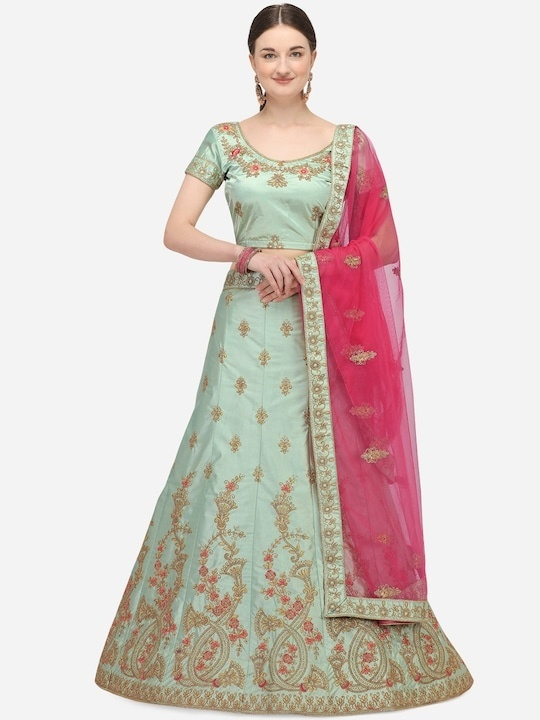

In [ ]:
image_path =os.path.join(FASHION_MINI_DIR, test_df.iloc[0]["image_path"])
assert image_path == image_path_list[0]
image = Image.open(image_path)
display(image)

In [ ]:
query = caption_list[0]
print(query)
query = query.replace("&amp;", "&").replace("& amp;", "&").replace(" ", " ")
print(query)

Hijau Limau & amp; Lehenga &amp; Blus Tanpa Jahitan dengan Dupatta
Hijau Limau & Lehenga & Blus Tanpa Jahitan dengan Dupatta


['/content/gdrive/MyDrive/Nella/CLIP/data/indo_fashion_mini/images/test/598.jpeg', '/content/gdrive/MyDrive/Nella/CLIP/data/indo_fashion_mini/images/test/605.jpeg', '/content/gdrive/MyDrive/Nella/CLIP/data/indo_fashion_mini/images/test/594.jpeg']


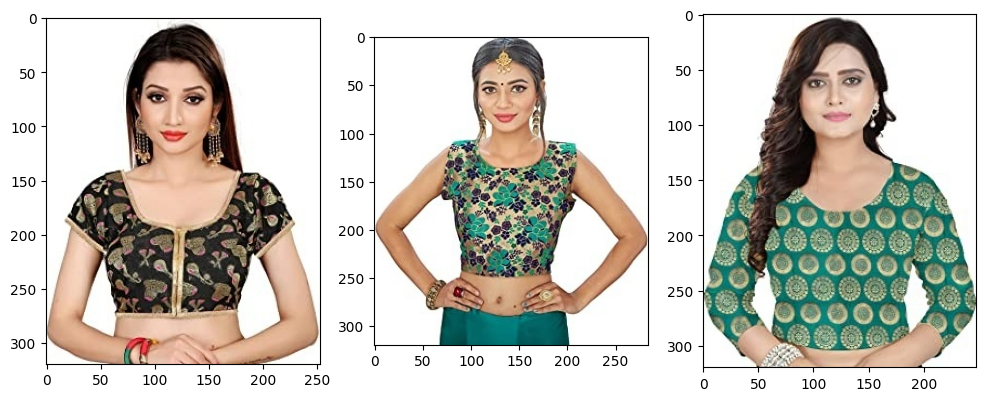

In [ ]:
paths, images = image_retrieval(query, image_path_list, base_image_embeds, processor, model_base, top_k=3)
print(paths)
plot_images(images)

In [ ]:
paths, images = image_retrieval(query, image_path_list, best_image_embeds, processor, model_best, top_k=3)
print(paths)
plot_images(images)

['/content/gdrive/MyDrive/Nella/CLIP/data/indo_fashion_mini/images/test/3789.jpeg', '/content/gdrive/MyDrive/Nella/CLIP/data/indo_fashion_mini/images/test/3723.jpeg', '/content/gdrive/MyDrive/Nella/CLIP/data/indo_fashion_mini/images/test/3892.jpeg']


#### Using Input Prompt

In [18]:
# reference: https://colab.research.google.com/drive/1zObyENn4rZgHeHzzXvfUPIgZ9mvsh-Hv?usp=sharing#scrollTo=IdEMZzjRxus8

query = "Jaket Nehru Polos Tanpa Lengan Fit Biasa Rami Pria" #@param {type:"string"}

# paths, images = image_retrieval(caption, image_path_list, base_image_embeds, processor, model_base, top_k=1)
paths, images = image_retrieval(query, image_path_list, best_image_embeds, processor, model_best, top_k=1)
print(paths)
plot_images(images)

['/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/Project/CLIP/data/indo_fashion_mini/images/test/5167.jpeg']
